### IBM AutoAI-SDK Auto-Generated Notebook v1.14.1

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview
-  pipeline evaluation
-  pipeline deployment and webservice scoring.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training data](#train_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery and testing (optional)](#refinery)  
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `ibm_watson_machine_learning` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed.

In [1]:
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 1.7 MB 11.7 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.22
    Uninstalling ibm-watson-machine-learning-1.0.22:
      Successfully uninstalled ibm-watson-machine-learning-1.0.22


In [2]:
!pip install -U autoai-libs

     |████████████████████████████████| 4.0 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 55.7 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell defines COS credentials required to retrieve AutoAI pipeline.

In [3]:
# @hidden_cell
from ibm_watson_machine_learning.helpers import DataConnection, S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key='HgCDG8fHLwg6DvXJmKq_IB41b9gRlz0TmnySNEZyBiJ2',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
        location=S3Location(
        bucket='insuranceproject-donotdelete-pr-nobeyzifr2mjpd',
        path='insurance.csv'
    ))
]
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key='HgCDG8fHLwg6DvXJmKq_IB41b9gRlz0TmnySNEZyBiJ2',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
    location=S3Location(
        bucket='insuranceproject-donotdelete-pr-nobeyzifr2mjpd',
        path='auto_ml/3e9122e0-e49d-4754-969f-1378d8e06649/wml_data/d8fab766-0613-4787-9244-640c571fa524/data/automl',
        model_location='auto_ml/3e9122e0-e49d-4754-969f-1378d8e06649/wml_data/d8fab766-0613-4787-9244-640c571fa524/data/automl/cognito_output/Pipeline5/model.pickle',
        training_status='auto_ml/3e9122e0-e49d-4754-969f-1378d8e06649/wml_data/d8fab766-0613-4787-9244-640c571fa524/training-status.json'
    ))

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio

In [4]:
experiment_metadata = dict(
   prediction_type='regression',
   prediction_column='expenses',
   test_size=0.15,
   scoring='neg_root_mean_squared_error',
   project_id='88d1e74e-2c6f-4087-9033-e7cd1ead0e52',
   csv_separator=',',
   random_state=33,
   max_number_of_estimators=2,
   training_data_reference = training_data_reference,
   training_result_reference = training_result_reference,
   deployment_url='https://us-south.ml.cloud.ibm.com')

pipeline_name='Pipeline_7'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [5]:
from ibm_watson_machine_learning.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [6]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [7]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from lale.operators import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from lale.operators import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TAM
import autoai_libs.cognito.transforms.transform_extras
from autoai_libs.cognito.transforms.transform_utils import FS1
from sklearn.ensemble import RandomForestRegressor

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 3, 4, 5])
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=["int_num", "char_str", "int_num", "char_str", "char_str"],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[], [], [], [], []],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
    ],
    known_values_list=[
        [
            18,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30,
            31,
            32,
            33,
            34,
            35,
            36,
            37,
            38,
            39,
            40,
            41,
            42,
            43,
            44,
            45,
            46,
            47,
            48,
            49,
            50,
            51,
            52,
            53,
            54,
            55,
            56,
            57,
            58,
            59,
            60,
            61,
            62,
            63,
            64,
        ],
        [
            52149379001264932068757487059177351405,
            10381015089147753033583386570985939629,
        ],
        [0, 1, 2, 3, 4, 5],
        [
            169662019754859674907370307324476606919,
            220736790854050750400968561922076059550,
        ],
        [
            282434315002569778634924514018021374699,
            198048322354213518034649196306846275475,
            335271285961090502450971320427760086836,
            4876168229072992032963539073510977133,
        ],
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=float("nan"),
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[2])
float_str2_float = FloatStr2Float(
    dtypes_list=["float_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0, permutation_indices=[0, 1, 3, 4, 5, 2]
)
tam = TAM(
    tans_class=autoai_libs.cognito.transforms.transform_extras.IsolationForestAnomaly,
    name="isoforestanomaly",
    col_names=["age", "sex", "bmi", "children", "smoker", "region"],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1 = FS1(
    cols_ids_must_keep=range(0, 6),
    additional_col_count_to_keep=8,
    ptype="regression",
)
random_forest_regressor = RandomForestRegressor(
    criterion="friedman_mse",
    max_depth=5,
    max_features=0.7596395560344726,
    min_samples_leaf=5,
    min_samples_split=3,
    n_estimators=91,
    n_jobs=4,
    random_state=33,
)
pipeline = make_pipeline(
    union, numpy_permute_array, tam, fs1, random_forest_regressor
)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


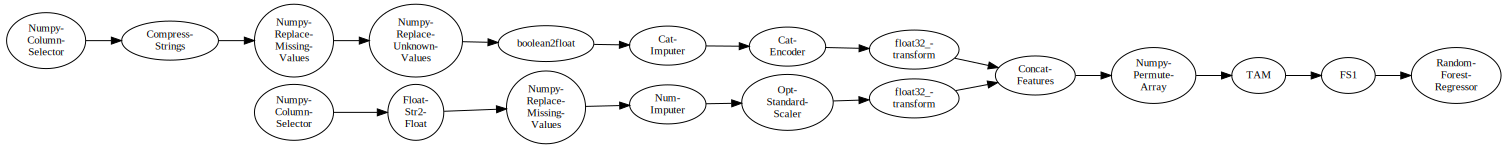

In [8]:
pipeline_model.visualize()

<a id="train_read"></a>
### Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [9]:
train_df = optimizer.get_data_connections()[0].read()
test_df = train_df.sample(n=5).drop([experiment_metadata['prediction_column']], axis=1)

<a id="test_model"></a>
### Test pipeline model locally
You can predict target value using trained AutoAI model by calling `predict()`.

In [10]:
y_pred = pipeline_model.predict(test_df.values)
print(y_pred)

[ 6347.28108856  9377.54439586  8644.93633706 12568.99955456
 35415.76723253]


<a id="refinery"></a>
## Pipeline refinery and testing (optional)

In this section you will learn how to refine and retrain the best pipeline returned by AutoAI.
It can be performed by:
 - modifying pipeline definition source code
 - using [lale](https://lale.readthedocs.io/en/latest/) library for semi-automated data science

**Note**: In order to run this section change following cells to 'code' cell.

<a id="pipeline_definition"></a>
### Pipeline definition source code
Following cell lets you experiment with pipeline definition in python, e.g. change steps parameters.

It will inject pipeline definition to the next cell.

<a id="lale_library"></a>
### Lale library

**Note**: This is only an exemplary usage of lale package. You can import more different estimators to refine downloaded pipeline model.

#### Import estimators

<a id="decomposition_definition"></a>
#### Pipeline decomposition and new definition
In this step the last stage from pipeline is removed.

<a id="new_optimizer"></a>
#### New optimizer `hyperopt` configuration and training

This section can introduce other results than the original one and it should be used
by more advanced users.

New pipeline is re-trained by passing train data to it and calling `fit` method.

Following cell performs dataset split for refined pipeline model.

<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="wml_credentials"></a>
### Connection to WML
Authenticate the Watson Machine Learning service on IBM Cloud.

**Tip**: Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**Note:** You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` in the following cell.

In [11]:
api_key = "h4QaV-YUM6uhsqOAAhtGgFnn9aX9bpnbtMloRLrN_vRU"

wml_credentials = {
  "apikey": api_key,
  "url": experiment_metadata["deployment_url"]
}

<a id="deployment"></a>

### Create deployment
 **Action**: If you want to deploy refined pipeline please change the `pipeline_name` to
`new_pipeline`.
If you prefer you can also change the `deployment_name`.

 **Action**: To perform deployment please specify `target_space_id`.


In [ ]:
target_space_id = "PUT_YOUR_TARGET_SPACE_ID_HERE"

from ibm_watson_machine_learning.deployment import WebService
service = WebService(source_wml_credentials=wml_credentials,
                     target_wml_credentials=wml_credentials,
                     source_project_id=experiment_metadata['project_id'],
                     target_space_id=target_space_id)
service.create(
model=pipeline_name,
metadata=experiment_metadata,
deployment_name=f'{pipeline_name}_webservice'
)

Deployment object could be printed to show basic information:

In [ ]:
print(service)

To be able to show all available information about deployment use `.get_params()` method:

In [ ]:
service.get_params()

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [ ]:
predictions = service.score(payload=test_df)
predictions

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by:
```
 service = WebService(target_wml_credentials=wml_credentials,
                      target_space_id=target_space_id)
```
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

<a id="delete_deployment"></a>
### Delete deployment

You can delete an existing deployment by calling `service.delete()`.

<a id="authors"></a>
### Authors

Licensed Materials - Copyright © 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___